# **GSoC 2024 QMLHEP Task II**
---

## **Classical Graph Neural Network (GNN)**
In this task, it was used ParticleNet's data for Quark/Gluon jet classification using Graph Neural Networks choosing 2 graph-based architectures to classify jets as being quarks or gluons.


#### **Resources**
* [PyTorch Geometric Documentation](https://pytorch-geometric.readthedocs.io/en/latest/)


### Libraries and functions

In [1]:
# Import all required libraries

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.nn import Linear, Parameter
from torch_geometric.data import Data
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv

from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn import (
    Aggregation,
    MaxAggregation,
    MeanAggregation,
    MultiAggregation,
    SAGEConv,
    SoftmaxAggregation,
    StdAggregation,
    SumAggregation,
    VarAggregation,
)



In [2]:
# Define all necessary functions

def load_QGjets(file: str) -> tuple:
    """
    Load quark-gluon (QG) jet data from a NumPy .npz file.

    ## Args:
        file : str 
            The path to the .npz file containing the QG jet data.

    ## Returns:
        jets : ndarray
            Contains the QG jets data
        labels : ndarray
            Contains the corresponding labels
    """

    # Load data from the npz file
    data = np.load(file)

    # Access the arrays stored in the file
    jets = data['X']
    labels = data['y']

    # Close the file
    data.close()

    return jets, labels

def graph_data(jet: np.ndarray, label: int, threshold:float):

    """
    Convert jet data into a graph representation suitable for Graph Neural Networks (GNNs).

    ## Args:
        jet : np.ndarray 
            Array representing the jet data, where each row corresponds to a particle
        and each column corresponds to a feature of the particle (pt, rapidity,
        azimuthal angle, pdgID).

        label : int
            The label associated with the graph, it represents whether it is a quark jet or a gluon jet.

        threshold : float
            The maximum value of the azimuthal angle difference between two particles to consider them as connected.

    ## Returns:
        data : torch_geometric.data.Data
            A PyTorch Geometric data instance containing the node and edge information of the graph.
    """
    
    # Check which rows are all zeros
    non_zero_rows = np.any(jet != 0, axis=1)

    # Filter out the rows that are all zeros
    node_data = jet[non_zero_rows, :]

    # Initialize the source and target arrays
    source = np.array([])
    target = np.array([])
        
    # Fill the source and target arrays based on the angle difference
    for i in range(len(node_data)):
        for j in range(len(node_data)):
            if i != j:
                if abs(node_data[i][2] - node_data[j][2]) < threshold:
                    source = np.append(source, [i])
                    target = np.append(target, [j])
    edge_data = np.array([source, target])
                
    # Create the edge information tensor   
    edge_index = torch.tensor(edge_data, dtype=torch.long)

    # Create the node information tensor
    x = torch.tensor(node_data, dtype=torch.float)

    # Create the label information tensor
    y = torch.tensor([label], dtype=torch.long)

    # Create a torch geometric data instance
    data = Data(x=x, edge_index=edge_index, y=y)

    return data


<a name="p1"></a>

---
# **Data preprocessing**
---

### Convert data into graphs
---

Before start, it is needed to transform the initial format of data into graph data. To project the point-cloud data set into a set of graphs, several considerations where taken into account:

- **nodes**: Each individual jet was taken as a whole graph, each particle in the jet were considered individual nodes. Modes features were extracted form the values of the traverse moement (pt), rapidity, azimuthal angle and particle identification number (pdgID). 

- **edges**: The spatial distribution of data is usually taken account to define the edges of a graph. In this work the only spatial feature was used. To determine edge connections, the azimuthal angle difference between each pair of particles in the jet was calculated. A thresshold was applied to define whether two particles are connected, pairs of particles  with azimuthal angle differences below this threshold we considered connected.

The threshold mentioned above was choosen by taking a small sample and training a GNN in order to find the value with better results.

In [3]:
# Create a subclass of torch_geometric.data.Dataset to store our graph data 
class CustomDataset(Dataset):
    def __init__(self, data_list):
        super(CustomDataset, self).__init__()
        self.data_list = data_list
    
    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

In [4]:
# load data from the npz file
jets, labels = load_QGjets('raw_data/QG_jets.npz')

# Create a list to store our graph data
dataset = []

for event in range(20000):
    graph = graph_data(jets[event], labels[event], 0.09)
    dataset.append(graph)

# Convert the list into a CustomDataset instance
dataset = CustomDataset(dataset)

# Get the first graph object.
data = dataset[0]  

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(x=[18, 4], edge_index=[2, 192], y=[1])
Number of nodes: 18
Number of edges: 192
Average node degree: 10.67
Has isolated nodes: False
Has self-loops: False
Is undirected: True


### Data spliting
---

In this part the data set is divided into a training subset and testing subset. Once done the dataset split, the train data subsets is divided again into smaller subsets called batches, this is done to make the training process easier. The split was done taking the $80\%$ of the data as training data and the remaining $20\%$ as test data.

In [5]:
# Shuffle dataset
dataset = dataset.shuffle()

train_samples = int(len(dataset)*0.8)

# Split data into train and test data
train_dataset = dataset[:train_samples]
test_dataset = dataset[train_samples:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 16000
Number of test graphs: 4000


In [6]:
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = True)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()


Step 1:
Number of graphs in the current batch: 128
DataBatch(x=[5274, 4], edge_index=[2, 124224], y=[128], batch=[5274], ptr=[129])

Step 2:
Number of graphs in the current batch: 128
DataBatch(x=[5669, 4], edge_index=[2, 137122], y=[128], batch=[5669], ptr=[129])

Step 3:
Number of graphs in the current batch: 128
DataBatch(x=[5337, 4], edge_index=[2, 121804], y=[128], batch=[5337], ptr=[129])

Step 4:
Number of graphs in the current batch: 128
DataBatch(x=[5459, 4], edge_index=[2, 122630], y=[128], batch=[5459], ptr=[129])

Step 5:
Number of graphs in the current batch: 128
DataBatch(x=[5568, 4], edge_index=[2, 132882], y=[128], batch=[5568], ptr=[129])

Step 6:
Number of graphs in the current batch: 128
DataBatch(x=[5671, 4], edge_index=[2, 137870], y=[128], batch=[5671], ptr=[129])

Step 7:
Number of graphs in the current batch: 128
DataBatch(x=[5627, 4], edge_index=[2, 135244], y=[128], batch=[5627], ptr=[129])

Step 8:
Number of graphs in the current batch: 128
DataBatch(x=[5553,

Step 60:
Number of graphs in the current batch: 128
DataBatch(x=[5656, 4], edge_index=[2, 135000], y=[128], batch=[5656], ptr=[129])

Step 61:
Number of graphs in the current batch: 128
DataBatch(x=[5348, 4], edge_index=[2, 129014], y=[128], batch=[5348], ptr=[129])

Step 62:
Number of graphs in the current batch: 128
DataBatch(x=[5722, 4], edge_index=[2, 140844], y=[128], batch=[5722], ptr=[129])

Step 63:
Number of graphs in the current batch: 128
DataBatch(x=[5539, 4], edge_index=[2, 136176], y=[128], batch=[5539], ptr=[129])

Step 64:
Number of graphs in the current batch: 128
DataBatch(x=[5261, 4], edge_index=[2, 121116], y=[128], batch=[5261], ptr=[129])

Step 65:
Number of graphs in the current batch: 128
DataBatch(x=[5678, 4], edge_index=[2, 138784], y=[128], batch=[5678], ptr=[129])

Step 66:
Number of graphs in the current batch: 128
DataBatch(x=[5882, 4], edge_index=[2, 149192], y=[128], batch=[5882], ptr=[129])

Step 67:
Number of graphs in the current batch: 128
DataBatch(

<a name="p2"></a>

---
# **Graph Neural Network Implementation**
---


## **First architecture**

The first model trained is a **Graph convolutional Network**, which is the most broadly applied model when dealing with graph-structured data. The architecture of the artificail neural network is:

- **input**: The input layer receives a tensor with a batch of 128 graphs, as the graphs are not connected to each other, the graph convolution just acts on each individual graph. the tensor size is the total number of the node features of all the 128 graphs in the batch.

- **Hidden Layers**: This model has two hidden graph convolutional layers with 64 output channels each. After the first graph convolution a ReLU activation is applied followed by a dropout regularization. After the second graph convolution, a global mean pool operation is applied to aggregate information from all nodes in the graph followed by another dropout regularization.

- **output**: The output layer of this model is composed by a linear layer which convert the embeddings into a vector of dimension two, this layer has a softmax activation function to generate the predicted probabilities for each class

In [7]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.lin = Linear(64, dataset.num_classes)

    def forward(self, x, edge_index, batch):     
        # First hidden layer 
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x= F.dropout(x, training=self.training)

        # Second hidden layer
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  
        x = F.dropout(x, p=0.5, training=self.training)

        # output layer
        x = self.lin(x)
        
        return F.log_softmax(x, dim=1)
        
model = GCN()
print(model)

GCN(
  (conv1): GCNConv(4, 64)
  (conv2): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


## **Training**

This model was trained in a mini-batch gradient descent fashion, using a Cross entropy as loss function:

$$
L = - \sum p(x) ln[q(x)]
$$

where $p(x)$ is the True probability distribution and $q(x)$ the predicted probability distribution. It was also used Adam algorithm as optimizer. The model was trained through 10 epochs and the accuracy model was computed for the train and test datasets. The model was trained using 16000 trainning samples and 4000 test samples.

In [17]:

model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.



In [18]:
train_accuracy_1 = []
test_accuracy_1 = []
for epoch in range(1, 30):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_accuracy_1.append(train_acc)
    test_accuracy_1.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.7318, Val Acc: 0.7362
Epoch: 002, Train Acc: 0.7562, Val Acc: 0.7532
Epoch: 003, Train Acc: 0.7606, Val Acc: 0.7562
Epoch: 004, Train Acc: 0.7661, Val Acc: 0.7638
Epoch: 005, Train Acc: 0.7586, Val Acc: 0.7512
Epoch: 006, Train Acc: 0.7624, Val Acc: 0.7600
Epoch: 007, Train Acc: 0.7491, Val Acc: 0.7468
Epoch: 008, Train Acc: 0.7673, Val Acc: 0.7680
Epoch: 009, Train Acc: 0.7706, Val Acc: 0.7642
Epoch: 010, Train Acc: 0.7591, Val Acc: 0.7525
Epoch: 011, Train Acc: 0.7634, Val Acc: 0.7645
Epoch: 012, Train Acc: 0.7645, Val Acc: 0.7640
Epoch: 013, Train Acc: 0.7536, Val Acc: 0.7595
Epoch: 014, Train Acc: 0.7646, Val Acc: 0.7618
Epoch: 015, Train Acc: 0.7591, Val Acc: 0.7625
Epoch: 016, Train Acc: 0.7602, Val Acc: 0.7650
Epoch: 017, Train Acc: 0.7634, Val Acc: 0.7675
Epoch: 018, Train Acc: 0.7479, Val Acc: 0.7478
Epoch: 019, Train Acc: 0.7688, Val Acc: 0.7652
Epoch: 020, Train Acc: 0.7646, Val Acc: 0.7578
Epoch: 021, Train Acc: 0.7590, Val Acc: 0.7582
Epoch: 022, T

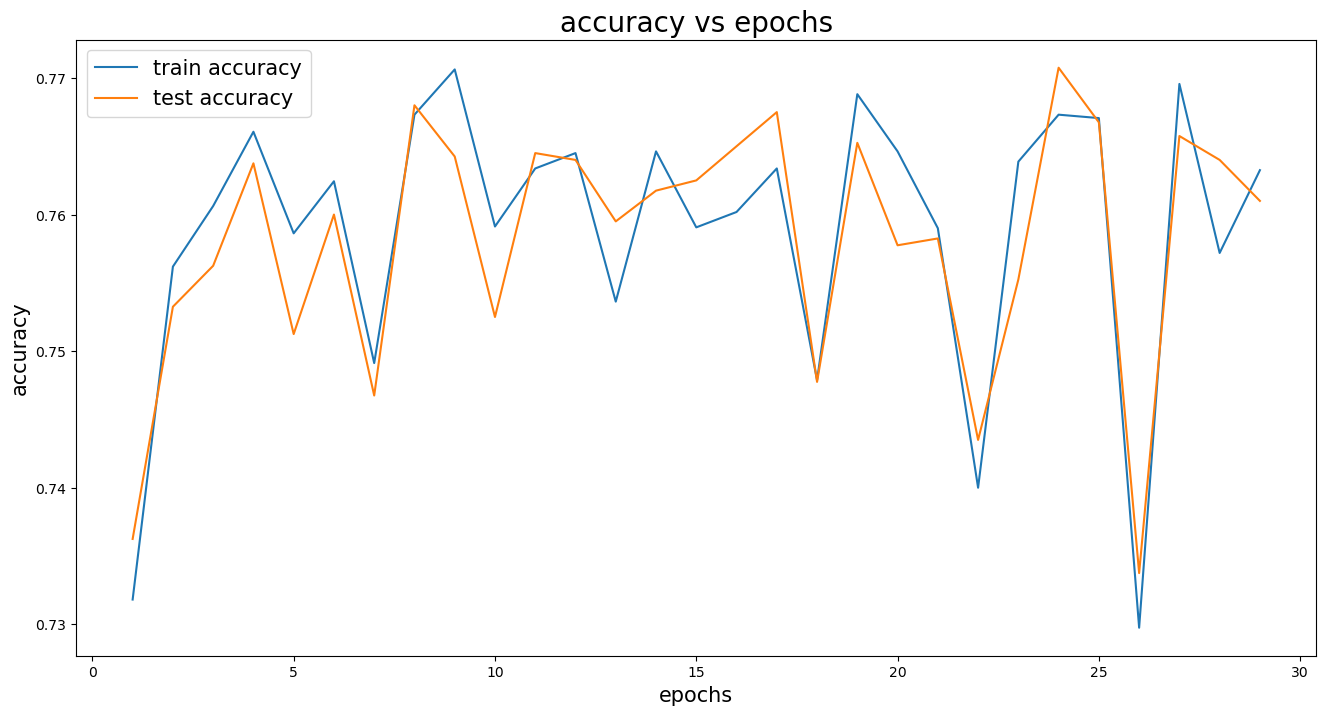

In [19]:
plt.figure(figsize=(16, 8))
plt.plot(range(1,30), train_accuracy_1, label='train accuracy')
plt.plot(range(1,30), test_accuracy_1, label='test accuracy')
plt.xlabel('epochs', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.title('accuracy vs epochs', fontsize=20)
plt.legend(fontsize=15)
plt.show()

## **Second architecture**

The second model trained is also a **Graph convolutional Network** The architecture of the artificail neural network is:

- **input**: The input layer receives a tensor with a batch of 128 graphs, as the graphs are not connected to each other, the graph convolution just acts on each individual graph. the tensor size is the total number of the node features of all the 128 graphs in the batch.

- **Hidden Layers**: This model has two hidden graph Sample and Aggregation convolutional (SAGEConv) layers with 128 output channels each and using standard deviation as aggregation function. After the first (SAGEConv) layer a ReLU activation is applied followed by a dropout regularization. After the second (SAGEConv) layer, a global mean pool operation is applied to aggregate information from all nodes in the graph followed by another dropout regularization.

- **output**: The output layer of this model is composed by a linear layer which convert the embeddings into a vector of dimension two, this layer has a softmax activation function to generate the predicted probabilities for each class

In [11]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, aggr='std', aggr_kwargs=None):
        super().__init__()
        self.conv1 = SAGEConv(
            dataset.num_node_features,
            hidden_channels,
            aggr=aggr,
            aggr_kwargs=aggr_kwargs,
        )
        self.conv2 = SAGEConv(
            hidden_channels,
            hidden_channels,
            aggr=aggr,
            aggr_kwargs=aggr_kwargs,
        )
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # First hidden layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x= F.dropout(x, training=self.training)

        # Second hidden layer
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  
        x = F.dropout(x, p=0.5, training=self.training)

        #output layer
        x = self.lin(x)
        
        return F.log_softmax(x, dim=1)
    
model = GNN(128)
print(model)

GNN(
  (conv1): SAGEConv(4, 128, aggr=std)
  (conv2): SAGEConv(128, 128, aggr=std)
  (lin): Linear(in_features=128, out_features=2, bias=True)
)


## **Training**

This second model was also trained in a mini-batch gradient descent fashion, using a Cross entropy as loss function:

$$
L = - \sum p(x) ln[q(x)]
$$

where $p(x)$ is the True probability distribution and $q(x)$ the predicted probability distribution. It was also used Adam algorithm as optimizer. The model was trained through 10 epochs and the accuracy model was computed for the train and test datasets. The model was trained using 16000 trainning samples and 4000 test samples. the same data was used to train both models.

In [12]:
model = GNN(128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.



In [13]:
train_accuracy = []
test_accuracy = []
for epoch in range(1, 30):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.6589, Val Acc: 0.6488
Epoch: 002, Train Acc: 0.6886, Val Acc: 0.6877
Epoch: 003, Train Acc: 0.6730, Val Acc: 0.6680
Epoch: 004, Train Acc: 0.6925, Val Acc: 0.6870
Epoch: 005, Train Acc: 0.7387, Val Acc: 0.7355
Epoch: 006, Train Acc: 0.7483, Val Acc: 0.7445
Epoch: 007, Train Acc: 0.6547, Val Acc: 0.6485
Epoch: 008, Train Acc: 0.7612, Val Acc: 0.7605
Epoch: 009, Train Acc: 0.6586, Val Acc: 0.6548
Epoch: 010, Train Acc: 0.7016, Val Acc: 0.7053
Epoch: 011, Train Acc: 0.7558, Val Acc: 0.7542
Epoch: 012, Train Acc: 0.7056, Val Acc: 0.7043
Epoch: 013, Train Acc: 0.7364, Val Acc: 0.7330
Epoch: 014, Train Acc: 0.7661, Val Acc: 0.7688
Epoch: 015, Train Acc: 0.7570, Val Acc: 0.7550
Epoch: 016, Train Acc: 0.7666, Val Acc: 0.7705
Epoch: 017, Train Acc: 0.7702, Val Acc: 0.7678
Epoch: 018, Train Acc: 0.7728, Val Acc: 0.7700
Epoch: 019, Train Acc: 0.7684, Val Acc: 0.7660
Epoch: 020, Train Acc: 0.7701, Val Acc: 0.7708
Epoch: 021, Train Acc: 0.7724, Val Acc: 0.7725
Epoch: 022, T

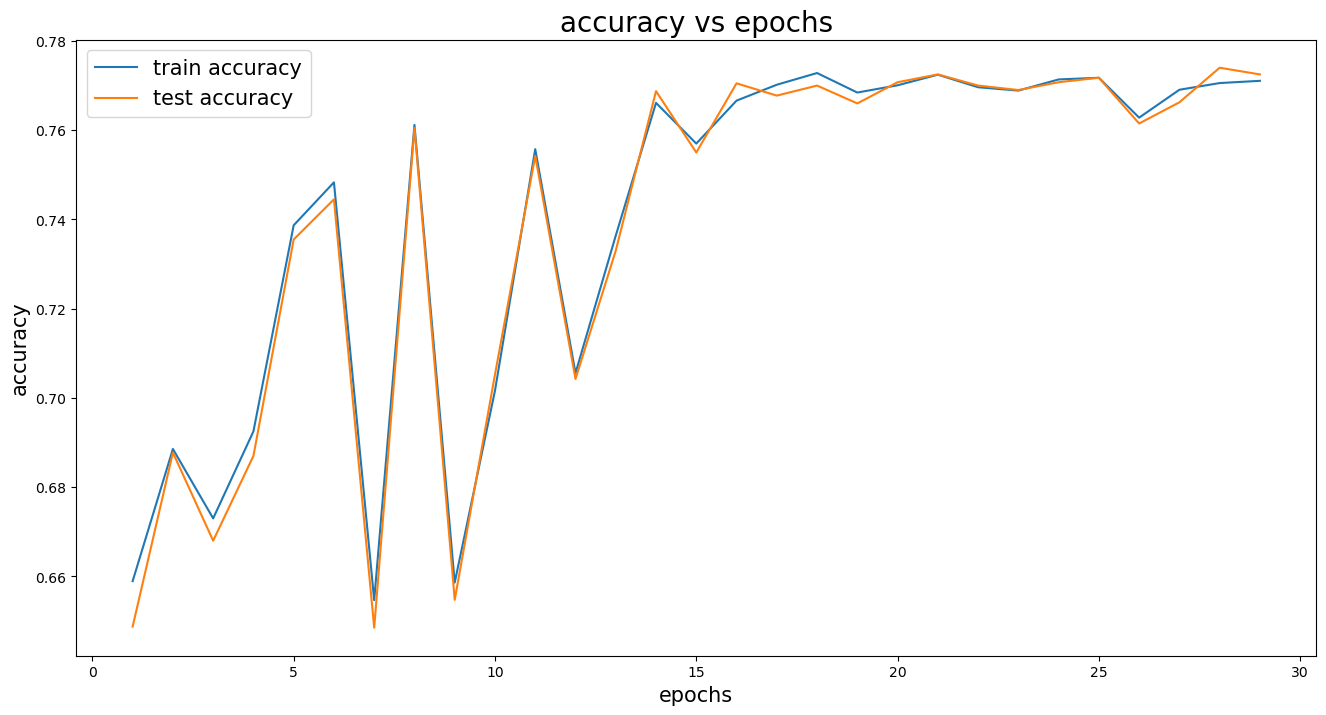

In [15]:
plt.figure(figsize=(16, 8))
plt.plot(range(1,30), train_accuracy, label='train accuracy')
plt.plot(range(1,30), test_accuracy, label='test accuracy')
plt.xlabel('epochs', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.title('accuracy vs epochs', fontsize=20)
plt.legend(fontsize=15)
plt.show()

# **Discussion**

From the graphs below, we can see the performance of each architecture through the training. 

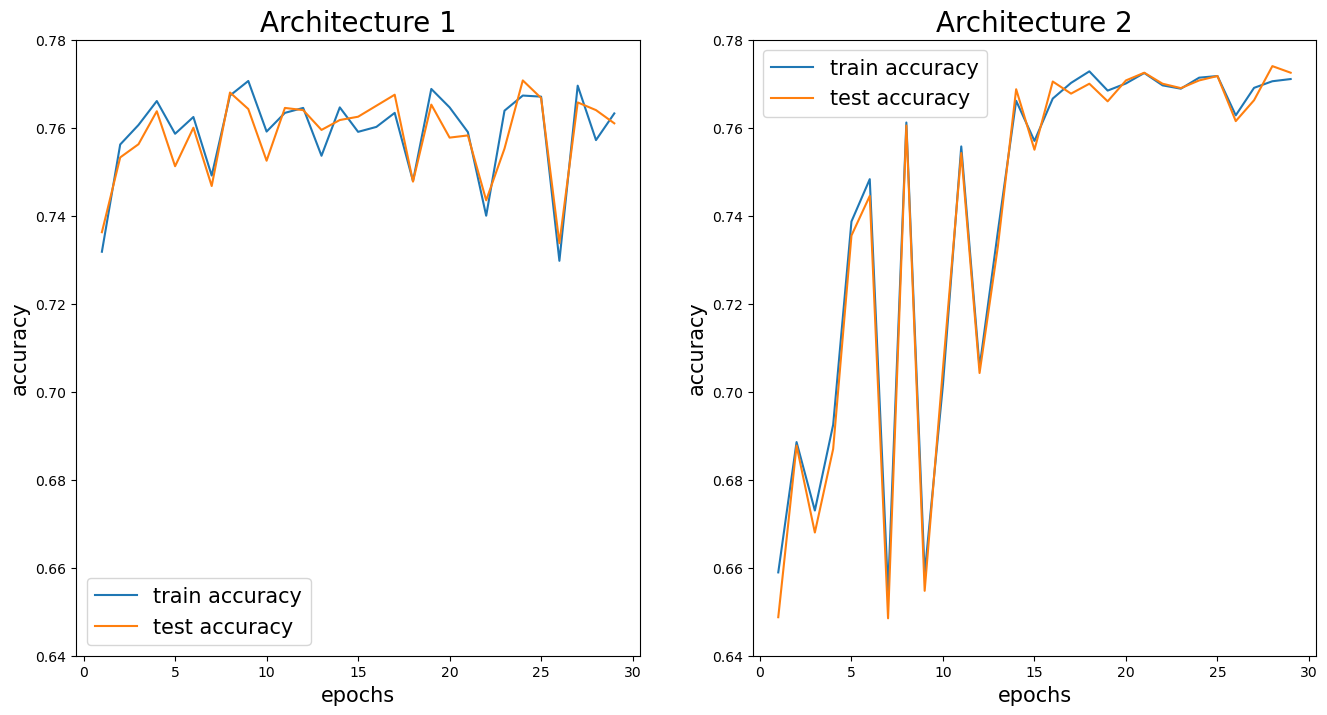

In [22]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(range(1,30), train_accuracy_1, label='train accuracy')
plt.plot(range(1,30), test_accuracy_1, label='test accuracy')
plt.xlabel('epochs', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.ylim([0.64, 0.78])
plt.title('Architecture 1', fontsize=20)
plt.legend(fontsize=15)
plt.subplot(1, 2, 2)
plt.plot(range(1,30), train_accuracy, label='train accuracy')
plt.plot(range(1,30), test_accuracy, label='test accuracy')
plt.xlabel('epochs', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.ylim([0.64, 0.78])
plt.title('Architecture 2', fontsize=20)
plt.legend(fontsize=15)
plt.show()

We can see the architecture one achive it maximum accuracy faster than the second one, it do not converges soflty and oscillates between several values. In the other hand the second architecture last longer in achive it maximum accuracy but it does converges softly.
Both architectures had a good performance when evaluate validation dataset, it accuracy values between the training and validation datasets behaves in a very similar way. 

In [23]:
print(f'Accuracy achieved by architecture 1 {test_accuracy_1[-1]}')
print(f'Accuracy achieved by architecture 2 {test_accuracy[-1]}')

Accuracy achieved by architecture 1 0.761
Accuracy achieved by architecture 2 0.7725


The accuracy achieved by the second architecture is slightly better than the achieved by the first architecture. We can choose one architecture or another based on out necessities, the first architecture allows us achieve a good accuracy in a single epoch, so if we have limitated computational resources, the first architecture is a good option. In the othr hand, if we would like a soft convergence and have computational resources enough, the second architecture could be a good option

---
# Further work
---

In orfer to imporve the performance of these arcchitectures, it is possible to try different thresholds for the angle difference to create the graphs, or try adding more layers, or even mix them and find out if it gives us a good result. The architectures presented in this work are very basic and a significant improvement can be done by increasing its complexity.